In [28]:
import LRUandJaxLIB
import pickle
import glob
import numpy as np
import jax.numpy as jnp
import more_itertools as mit
import matplotlib.pyplot as plt

In [29]:
# Load model from grid search
filepath = "grid_search7/*"

gloober = glob.glob(filepath)

hyper_and_model_parameters = {}

prev_best = [0,0]
# Find the model with the highest accuracy
for idx, glib in enumerate(gloober):
    with open(glib, "rb") as f:
        hyper_and_model_parameters = pickle.load(f)
        if np.max(hyper_and_model_parameters["Accuracy Measurements"]["Testing accuracy"]) > prev_best[0]:
            prev_best[0] = np.max(hyper_and_model_parameters["Accuracy Measurements"]["Testing accuracy"])
            prev_best[1] = idx

with open(gloober[prev_best[1]], "rb") as f:
    hyper_and_model_parameters = pickle.load(f)

max_epoch = np.argmax(hyper_and_model_parameters["Accuracy Measurements"]["Testing accuracy"])

model_parameters = hyper_and_model_parameters["Model Parameters"][max_epoch]

In [30]:
# Load the accuracy test set
filepath_dataset = "datasets/8mfsk/test_set_waveforms_CNO_[15, 20, 25, 30, 35]_and[0, 0.01, 0.02, 0.03, 0.04, 0.05].pkl"

with open(filepath_dataset, "rb") as f:
    waveforms = pickle.load(f)



In [31]:

def batched_zip(*iterables, batch_size):
    # Create batches for each iterable
    batches = [mit.batched(iterable, batch_size) for iterable in iterables]
    # Zip the batches together
    for batch_group in zip(*batches):
        yield tuple(zip(*batch_group))  # Zip within each batch

In [ ]:
# Perform the accuracy measurements
CNO_list =  [15, 20, 25, 30, 35]
freq_offset_percent_list = [0,0.01, 0.02, 0.03, 0.04, 0.05]
acc_results = []


for idx, CNO in enumerate(CNO_list):
    for idk, freq_offset_percent in enumerate(freq_offset_percent_list):
        input = jnp.array([wave[0] for wave in waveforms[idx][idk]]).reshape(len(waveforms[0][0])//10,10,len(waveforms[0][0][0][0]), 1)
        target = LRUandJaxLIB.one_hot(jnp.array([wave[1] for wave in waveforms[idx][idk]]).reshape(900,1), 9).reshape(900//10,10,9)
        acc_results.append(np.mean([LRUandJaxLIB.accuracy(jnp.array(x), jnp.array(y), model_parameters) for x, y in zip(input, target)]))



ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (5).

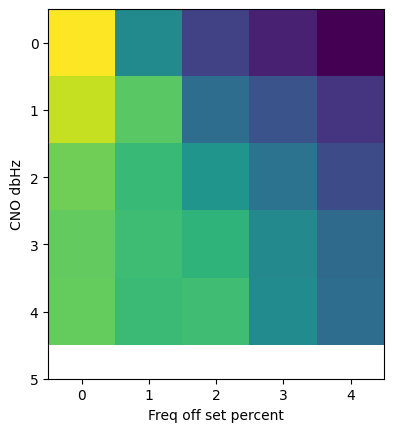

In [33]:
plt.imshow(jnp.array(acc_results).reshape(len(CNO_list), len(freq_offset_percent_list)))
plt.ylabel("CNO dbHz")
plt.xlabel("Freq off set percent")
plt.yticks(np.arange(0,6), CNO_list)
plt.xticks(np.arange(0,6), freq_offset_percent_list)
plt.colorbar()